## A Very Simple ``Dash`` App

In [1]:
from dash import Dash, html, Output, Input

app = Dash()

app.layout = html.Div([
    html.H1("A Simple App", id="title"),
    html.P("Structure things like you would in HTML"),
    html.Button("Click me to do something", id="button")
])

@app.callback(
    Output("title", "children"), # change this value
    Input("button", "n_clicks"), # when this changes
    prevent_initial_call = True
)
def update_title_on_buttonclick(n_clicks):
    print(n_clicks) # sure why not
    return "A Simple App **That Does Things!**"

app.run()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_9_2m1680375717.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_9_2m1680375717.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_9_2m1680375717.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_9_2m1680375717.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_9_1m1680375717.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/dcc/dash_core_components-shared.v2_9_1m1680375717.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-su

1


127.0.0.1 - - [22/Apr/2023 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


2


127.0.0.1 - - [22/Apr/2023 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


3
4


127.0.0.1 - - [22/Apr/2023 21:17:58] "POST /_dash-update-component HTTP/1.1" 200 -


5


## A Bit More Complicated App

Let's use bootstrap to spruce this up a bit

In [3]:
import dash_bootstrap_components as dbc

app = Dash(external_stylesheets=[dbc.themes.SKETCHY])

app.layout = html.Div([
    dbc.NavbarSimple(brand="Communities in Network Graphs"),
    dbc.Container([
        dbc.Row([
            dbc.Col(
                "Hello", width=3
            ),
            dbc.Col("Everyone", width=9)
        ])
    ])
])

app.run()


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2023 21:22:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:25] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v1_4_1m1682212359.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_favicon.ico?v=2.9.2 HTTP/1.1" 200 -


## Cytoscape

Now we can use the `dash-cytoscape` package to display our graph. Let's start with wireframe layout and then add in the functionality we need:

Coercing column 'status' to `list`
Coercing column 'languages' to `list`


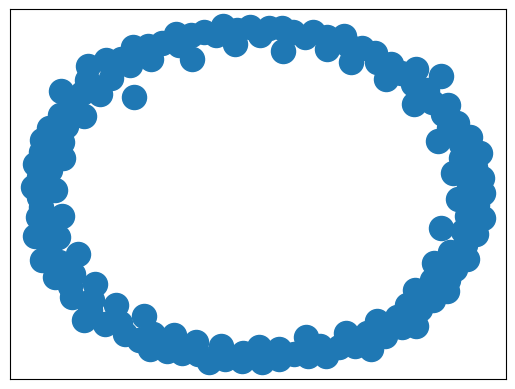

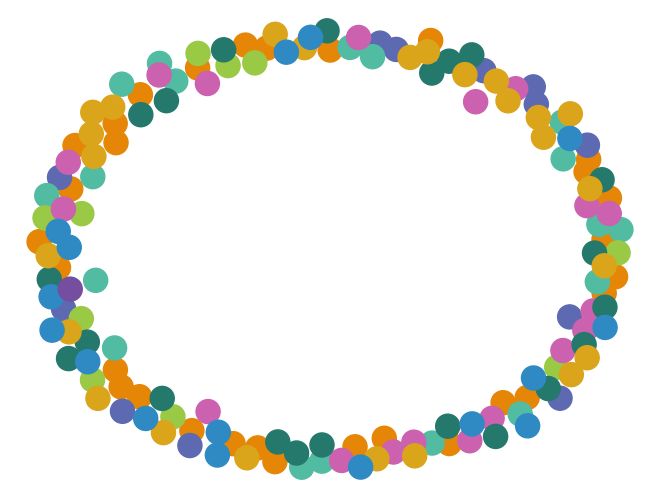

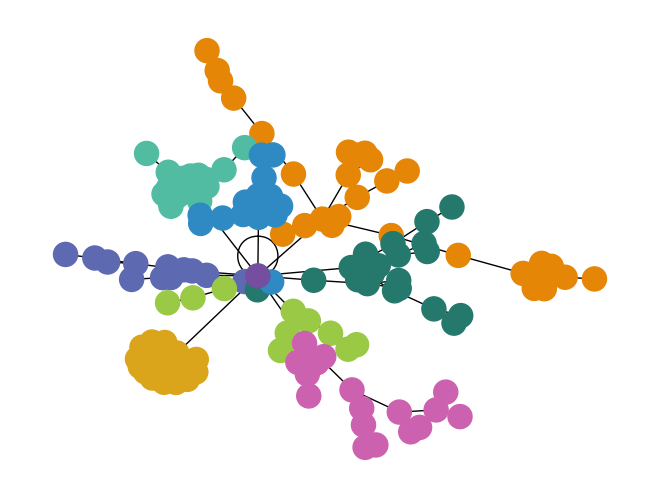

{'Jacob Barnett': ['Java', 'JavaScript'], 'Steve Acosta': ['JavaScript', 'Go'], 'John Smith': ['Typescript', 'Java', 'Python'], 'Heidi Cooper': ['Java'], 'Kristen Coleman': ['Java', 'JavaScript'], 'Oscar Bernard': ['JavaScript'], 'Jennifer Vaughn': ['JavaScript', 'Python', 'Java', 'Typescript', 'Go'], 'Scott Kennedy': ['Java', 'Python'], 'Nicholas Baker': ['Java', 'JavaScript', 'Python'], 'Scott Carter': ['Java'], 'Luis Wright': ['Java', 'Typescript', 'Python'], 'James Frey Jr.': ['Python'], 'Doris Foster': ['Java', 'JavaScript', 'Go', 'Python'], 'Lorraine Reed': ['Typescript', 'JavaScript', 'Java', 'Python'], 'Donald Tucker': ['Python'], 'Ronald Porter': ['Python'], 'Danielle White': ['Java', 'Python'], 'Paul Gill': ['Typescript', 'JavaScript', 'Java', 'Python'], 'Jill Long': ['Java'], 'Daniel Rich': ['Java'], 'Elizabeth Merritt': ['Typescript'], 'Steven Perkins': ['Python'], 'Joshua Miller': ['Java', 'JavaScript'], 'Heather Ferguson': ['Java', 'JavaScript'], 'Kaitlyn Wilson': ['Java'

In [14]:
%run "../Part 2 - Clustered Graph Attributes/Solution.ipynb"


In [15]:
def create_elements(attributes: list[str]=[]) -> list[dict]:
    """Generate a graph with connecting attributes and serialize it as cytoscape elements"""

In [16]:
elements = (
    nx.cytoscape_data(G)["elements"]["nodes"]
    + nx.cytoscape_data(G)["elements"]["edges"]
)

In [17]:
stylesheet = [
    # Group selectors
    {"selector": "node", "style": {"content": "data(label)", "width":"data(size)", "height":"data(size)"}},
    {"selector": """[type = "language"]""", "style":{"background-color":"yellow"}},
    {"selector": """[type = "tz"]""", "style":{"background-color":"orange"}},
    # Edge selectors
    {
        "selector": "edge",
        "style": {
            "content": "data(label)",
            "curve-style": "bezier",
            "line-color": "gray",
            "source-arrow-shape":"triangle",
            "font-size":"10px",
        },
    },
]

In [21]:
def stylesheet_(focus:str=CEO["name"], theme:str="light"):
    dark = theme == "dark"
    return [
    {
        "selector": "node",
        "style": {
            "font-size": 50,
            "color": "lightgrey" if dark else "darkgrey"
        }
    },
    {
        "selector": "edge",
        "style": {
            "line-color": "lightgrey" if dark else "darkgrey",
            "curve-style": "bezier",
            "width": 1,
            "opacity": 0.25,
            "font-size": 10,
            "text-rotation": "autorotate",
        },
    },    
    {"selector": "edge[?languages]", "style": {"label": "codes"}},
    {"selector": "edge[?tz]", "style": {"label": "lives in"}},
    {"selector": "edge[?team]", "style": {"label": "belongs to"}},
    {"selector": "edge[?apps]", "style": {"label": "uses"}},
    {"selector": "edge[?manager]", "style": {"label": "manages", "source-arrow-shape":"triangle"}},     
    {
        "selector": "node[?person]",
        "style": {
            "label": "data(label)",
            "background-color": "lightgreen" if dark else "green",
            "width": 25,
            "height": 25,            
            "font-size": 16
        },
    },
    {
        "selector": "node[?language]",
        "style": {
            "label": "data(name)",
            "background-color": "white" if dark else "black",
            "width": 5,
            "height": 5,
        },
    },
    {
        "selector": "node[?tz]",
        "style": {
            "label": "data(name)",
            "background-color": "white" if dark else "black",
            "width": 5,
            "height": 5,
        },
    },
    {
        "selector": f"node[id='{focus}']",
        "style":{
            "width": 50,
            "height": 50,
            "font-size": 35,
            "color":"skyblue",
            "background-color":"skyblue",
            "z-index":10            
        }
    },
    {
        "selector": "node[?app]",
        "style": {"label": "data(name)", "width": 5, "height": 5},
    },
]

In [22]:
from dash import dash, html, dcc, Input, Output
# from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
# JupyterDash.infer_jupyter_proxy_config()
cyto.load_extra_layouts()
dashboard = dash.Dash(__name__)
#dashboard = JupyterDash(__name__)

lyt = "cose-bilkent"
#lyt = "spread"
#lyt = "cose"

def layout():
    network = cyto.Cytoscape(
        id="network",
        layout={"name": lyt},
        style={"width": "100%", "height": "800px"},
        elements=elements,
        stylesheet=stylesheet_()
    )
    return html.Div([
        html.H1("The Network"),
        network
    ])


dashboard.layout = layout
dashboard.run(port=16900, debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:16900/

 * Serving Flask app '__main__'
 * Debug mode: on
